In [108]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt

In [109]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.d = d

    def forward(self, time):
        i = torch.arange(self.d)
        even = 1/2*(1-(-1)**i)
        odd = 1/2*(1+(-1)**i)
        x = 1/torch.exp(math.log(10000) * ((i - i%2) / self.d))
        x = time[:, None] * x[None, :]
        x = torch.sin(even*x) + torch.cos(odd*x)
        return x

In [110]:
class Block(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_dim, out_dim, 3, padding = 1),
            nn.BatchNorm2d(out_dim),
            nn.SiLU(),
        )
    def forward(self, x):
        x = self.layers(x)
        return x

In [111]:
class ResnetBlock(nn.Module):    
    def __init__(self, dim_in, dim_out, time_dim):
        super().__init__()
        self.time = nn.Linear(time_dim, dim_out)
        self.block1 = Block(dim_in, dim_out)
        self.block2 = Block(dim_out, dim_out)

    def forward(self, x, t):
        x = self.block1(x)
        x = torch.unsqueeze(torch.unsqueeze(self.time(t),-1),-1) + x
        x = self.block2(x)
        return x

In [190]:
class Unet(nn.Module):
    def __init__ (self, time_dim, dims, channels=3):
        super().__init__()

        self.time_embed = nn.Sequential(
                SinusoidalPositionEmbeddings(time_dim),
                nn.Linear(time_dim, 4*time_dim),
                nn.GELU(),
                nn.Linear(4*time_dim, 4*time_dim),
            )
        
        self.init_block = Block(channels, dims[0][0])
        self.encoder = nn.ModuleList([])
        self.mid_block = Block(dims[-1][-1], dims[-1][-1])
        self.decoder = nn.ModuleList([])
        self.final_block = Block(dims[0][0], channels)

        for (dim_in, dim_out) in dims:
            self.encoder.append(nn.ModuleList([
                ResnetBlock(dim_in, dim_out, 4*time_dim),
                ResnetBlock(dim_out, dim_out, 4*time_dim),
                nn.Conv2d(dim_out,dim_out, 4, 2, 1)
            ]))
        for (dim_in, dim_out) in reversed(dims):
            self.decoder.append(nn.ModuleList([
                ResnetBlock(2*dim_out, dim_in, 4*time_dim),
                ResnetBlock(dim_in, dim_in, 4*time_dim),
                nn.ConvTranspose2d(dim_out, dim_out, 4, 2, 1)
            ]))
        
    def forward(self, x, t):
        x = self.init_block(x)
        t = self.time_embed(t)
        res = []
        for B1, B2, downsample in self.encoder:
            print(x.shape)
            x = B1(x, t)
            x = B2(x, t)
            res.append(x)
            x = downsample(x)
            print(x.shape)
        x = self.mid_block(x)
        for B1, B2, upsample in self.decoder:
            print(x.shape)
            x = upsample(x)
            x = torch.cat((x, res.pop()), dim=1)
            x = B1(x, t)
            x = B2(x, t)
            print(x.shape)
        x = self.final_block(x)

In [191]:
A = Unet(10, [(5,6), (6,8)])

In [192]:
A(torch.ones((10,3,24, 24)), torch.arange(10))

torch.Size([10, 5, 24, 24])
torch.Size([10, 6, 12, 12])
torch.Size([10, 6, 12, 12])
torch.Size([10, 8, 6, 6])
torch.Size([10, 8, 6, 6])
torch.Size([10, 6, 12, 12])
torch.Size([10, 6, 12, 12])
torch.Size([10, 5, 24, 24])


In [193]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)


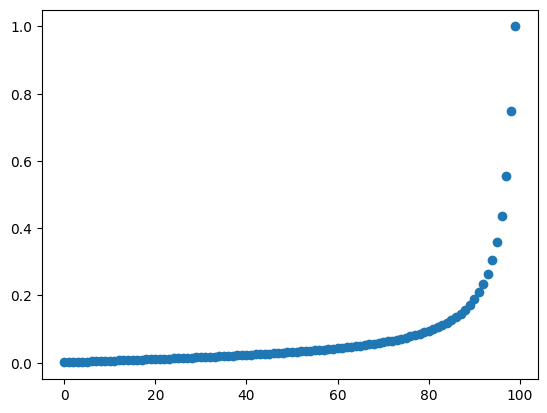

In [195]:
plt.scatter(torch.arange(100),cosine_beta_schedule(100))